### Parameters analyses

In [7]:
# import related libraries

import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt

#-----------------------------------
import warnings
warnings.filterwarnings("ignore")

In [8]:
# download data
data = pd.read_csv(r'processed_data.csv')

#### On a tree-based models

In [9]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

data_copy = copy.deepcopy(data)

X = data_copy.drop(['event_attributes', 'event_name', 'userid', 'event_created_date'], axis=1)
y = (data_copy['event_name'] == 'Subscription Premium Cancel').astype(int)


le = LabelEncoder()
X['user_state'] = le.fit_transform(X['user_state'])
X['event_platform'] = le.fit_transform(X['event_platform'])
X['device_manufacture'] = le.fit_transform(X['device_manufacture'])
X['device_model'] = le.fit_transform(X['device_model'])

In [10]:
dec_tr_cls = RandomForestClassifier(random_state=42, max_depth=5)
dec_tr_cls.fit(X, y)

RandomForestClassifier(max_depth=5, random_state=42)

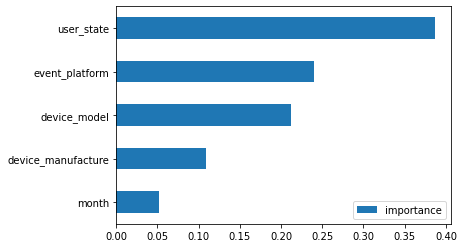

In [11]:
imp = pd.DataFrame(dec_tr_cls.feature_importances_, index=X.columns, columns=['importance'])
imp.sort_values('importance')[-10:].plot(kind='barh');

We can see that the most important features is user_state and event_platform

#### RNN

In [13]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Embedding, Activation
from keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Prepare the data for processing
userid = data['userid']
event_name = data['event_name']

# One-hot encode the event names
vocab_size = len(set(event_name))
encoded_docs = [one_hot(d, vocab_size) for d in event_name]

# Pad the sequences to make all sequences of the same length
max_length = max([len(d) for d in encoded_docs])
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

# Convert the target variable to a categorical variable
le = LabelEncoder()
y = le.fit_transform(data['event_name'])

# Split the data into training and testing sets
train_X = padded_docs[:int(len(padded_docs)*0.8)]
train_y = y[:int(len(padded_docs)*0.8)]
test_X = padded_docs[int(len(padded_docs)*0.8):]
test_y = y[int(len(padded_docs)*0.8):]

# Define the model
model = Sequential()
model.add(Embedding(vocab_size, 8, input_length=max_length))
model.add(SimpleRNN(128))
model.add(Dense(1, activation='sigmoid'))
#model.add(layers.Activation('softmax'))
model.compile(loss='poisson', optimizer='adam', metrics=['categorical_accuracy'])

# Fit the model
history = model.fit(train_X, train_y, epochs=10, batch_size=256, validation_data=(test_X, test_y))

Epoch 1/10
69/69 [==============================] - 2s 10ms/step - loss: 2.0684 - categorical_accuracy: 1.0000 - val_loss: 1.0001 - val_categorical_accuracy: 1.0000
Epoch 2/10
69/69 [==============================] - 0s 5ms/step - loss: 1.0001 - categorical_accuracy: 1.0000 - val_loss: 1.0001 - val_categorical_accuracy: 1.0000
Epoch 3/10
69/69 [==============================] - 0s 6ms/step - loss: 1.0001 - categorical_accuracy: 1.0000 - val_loss: 1.0001 - val_categorical_accuracy: 1.0000
Epoch 4/10
69/69 [==============================] - 0s 5ms/step - loss: 1.0001 - categorical_accuracy: 1.0000 - val_loss: 1.0001 - val_categorical_accuracy: 1.0000
Epoch 5/10
69/69 [==============================] - 0s 5ms/step - loss: 1.0001 - categorical_accuracy: 1.0000 - val_loss: 1.0001 - val_categorical_accuracy: 1.0000
Epoch 6/10
69/69 [==============================] - 0s 5ms/step - loss: 1.0001 - categorical_accuracy: 1.0000 - val_loss: 1.0001 - val_categorical_accuracy: 1.0000
Epoch 7/10
69/6

In [14]:
weights = model.layers[0].get_weights()[0]
importances = np.sum(np.abs(weights), axis=0)
print('Feature importances:', importances)
data.columns

Feature importances: [0.78538024 0.7450611  0.5683033  0.6364747  0.7315543  0.82835793
 0.7506337  0.56572896]


Index(['userid', 'user_state', 'event_name', 'event_attributes',
       'event_created_date', 'event_platform', 'device_manufacture',
       'device_model', 'month'],
      dtype='object')

As in previous analyses we have the most important features - user_state, but now also important device_manufacture and device_model. Let's look at it

In [15]:
(data.query("event_name == 'Subscription Premium Cancel'"). \
user_state.value_counts() / data.drop_duplicates(subset=['userid']).user_state.value_counts()).sort_values(ascending=False)

AR       0.166667
MD       0.135135
MA       0.121212
IN       0.117647
IL       0.101852
CA       0.093823
DE       0.090909
FL       0.078313
NJ       0.076923
OK       0.068966
AZ       0.066667
VA       0.062937
NC       0.062500
TX       0.059379
WI       0.055556
PA       0.054545
other    0.047619
NY       0.013575
CT            NaN
MI            NaN
MO            NaN
Name: user_state, dtype: float64

We can see that every 6th user from Arizona cancels Premium, however only 1 from 100 users from New York cancels his Premium

### Interim findings
Based on tree-models and Recurrent Neural Networks we can say that the most important feature for future premium cancellation is user_state. Most likely to unsubscribe are users from Arizona, Maryland, Massachusetts, Indiana and Illinois, least - from New York, Connecticut, Michigan and Missouri.

# Findings - check README